In [10]:
import gpxpy

import pandas as pd
import numpy as np

from sklearn.neighbors import BallTree

import matplotlib.pyplot as plt
import contextily as ctx

from geopy.distance import geodesic

In [7]:
osm_df = pd.read_csv('../gpx/30-08-2024/nodes.csv')
osm_df.head(5)

,node_id,lat,lon
0,5629422886,20.993104,105.870125
1,5629422911,20.991126,105.869104
2,5710080989,20.992102,105.870164
3,8830797998,20.990562,105.869376
4,8830798000,20.990588,105.869328


In [11]:
def parse_gpx(filepath):
    gpx_file = open(filepath, 'r')
    gpx = gpxpy.parse(gpx_file)

    data = []

    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                lat, lng = point.latitude, point.longitude
                data.append({
                    'lat': lat, 
                    'lon': lng,
                })

    df = pd.DataFrame(data)

    distances = []
    for i in range(1, len(df)):
        prev_point = (df.iloc[i-1]['lat'], df.iloc[i-1]['lon'])
        curr_point = (df.iloc[i]['lat'], df.iloc[i]['lon'])
        distance = geodesic(prev_point, curr_point).meters
        distances.append(distance)

    df['distance'] = [0] + distances
    df['cumulative_distance'] = df['distance'].cumsum()
    
    return df

gpx_df = parse_gpx('../gpx/30-08-2024/Morning_Run.gpx')
gpx_df.head(5)

,lat,lon,distance,cumulative_distance
0,20.992665,105.867727,0.000000,0.000000
1,20.992665,105.867727,0.000000,0.000000
2,20.992678,105.867707,2.529032,2.529032
3,20.992688,105.867685,2.541318,5.070350
4,20.992683,105.867650,3.681006,8.751356


In [12]:
# Convert coordinates to radians
osm_coords = np.deg2rad(osm_df[['lat', 'lon']])
gpx_coords = np.deg2rad(gpx_df[['lat', 'lon']])

# Create a BallTree for nearest neighbor search
tree = BallTree(osm_coords, metric='haversine')

# Find the nearest neighbors in OSM data
distances, indices = tree.query(gpx_coords, k=1)

# Add the results to the DataFrame
gpx_df['nearest_index'] = indices.flatten()
gpx_df['distance_meters'] = distances.flatten() * 6371000 # Earth's radius in meters

# Extract and assign the matched OSM node details
gpx_df[[
    'node_id', 
    'node_lat', 
    'node_lon',
]] = osm_df.iloc[gpx_df['nearest_index']][[
    'node_id', 
    'lat', 
    'lon',
]].values

# Convert node_id to string to avoid scientific notation
gpx_df['node_id'] = gpx_df['node_id'].apply(lambda x: f'{int(x)}')

gpx_df.head(5)

,lat,lon,distance,cumulative_distance,nearest_index,distance_meters,node_id,node_lat,node_lon
0,20.992665,105.867727,0.000000,0.000000,150,19.126360,12098983495,20.992833,105.867767
1,20.992665,105.867727,0.000000,0.000000,150,19.126360,12098983495,20.992833,105.867767
2,20.992678,105.867707,2.529032,2.529032,150,18.323062,12098983495,20.992833,105.867767
3,20.992688,105.867685,2.541318,5.070350,150,18.237241,12098983495,20.992833,105.867767
4,20.992683,105.867650,3.681006,8.751356,150,20.645863,12098983495,20.992833,105.867767


In [13]:
gpx_df['distance_meters'].describe()

count    4614.000000
mean       22.594719
std        18.071115
min         0.282629
25%         9.702796
50%        17.724954
75%        30.099927
max       101.415521
Name: distance_meters, dtype: float64

In [14]:
gpx_df['node_id'].nunique()

167

In [15]:
gpx_df[['lat', 'lon']].nunique()

lat    2477
lon    1844
dtype: int64

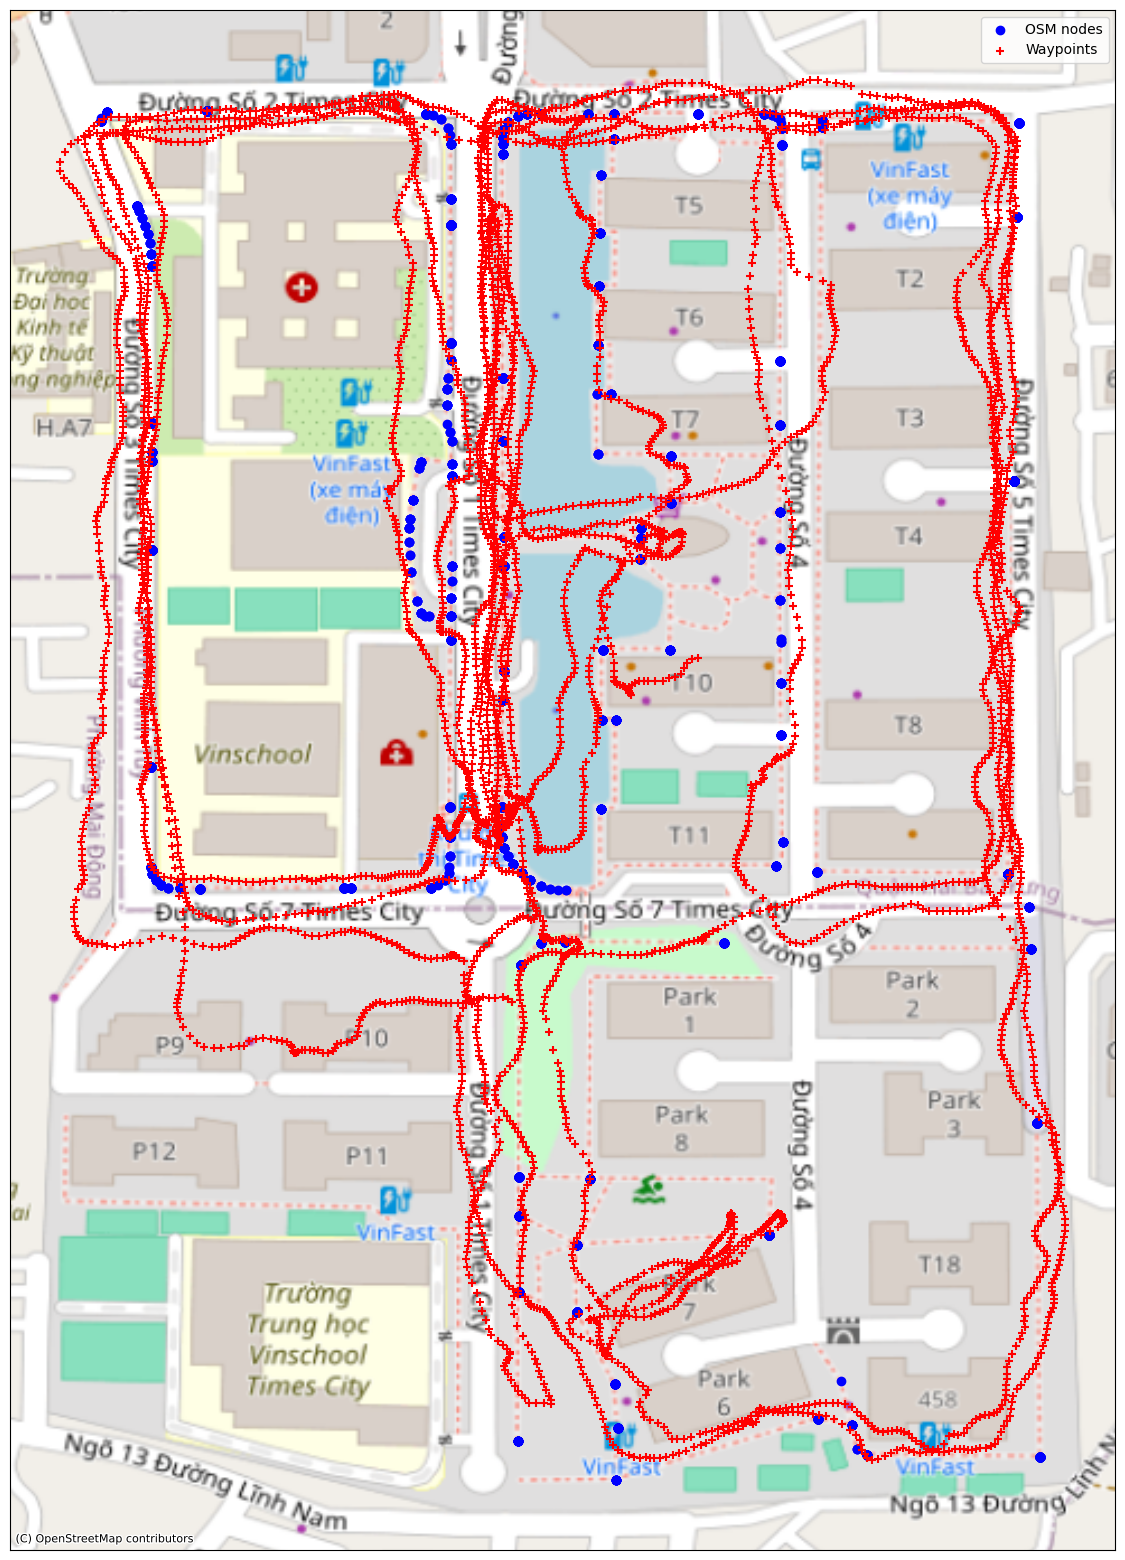

In [17]:
def plot(df):
    plt.figure(figsize=(30, 20))
    plt.scatter(df['node_lon'], df['node_lat'], color='blue', marker='o', label='OSM nodes')
    plt.scatter(df['lon'], df['lat'], color='red', marker='+', label='Waypoints')
    ctx.add_basemap(plt.gca(), crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
    plt.legend()
    plt.xticks([], [])
    plt.yticks([], [])
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    plt.show()    
    
plot(gpx_df)

In [23]:
gpx_df['node_lat_shifted'] = gpx_df['node_lat'].shift()
gpx_df['node_lon_shifted'] = gpx_df['node_lon'].shift()

def haversine(row):
    if pd.isna(row['node_lat_shifted']) or pd.isna(row['node_lon_shifted']):
        return 0  # No distance for the first row
    return geodesic((row['node_lat'], row['node_lon']), 
                    (row['node_lat_shifted'], row['node_lon_shifted'])).meters

gpx_df['node_distance'] = gpx_df.apply(haversine, axis=1)
gpx_df['cumulative_node_distance'] = gpx_df['node_distance'].cumsum()

print(
    gpx_df.iloc[-1]['cumulative_distance'],
    '(original)',
    gpx_df.iloc[-1]['cumulative_node_distance'],
    '(matched)',
)

13735.046972819397 (original) 14462.499697455976 (matched)
